In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


In [9]:
class FeedforwardNN(nn.Module):
    def __init__(self):
        super(FeedforwardNN, self).__init__()
        self.flatten = nn.Flatten()
        self.model = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.model(x)
        return x


In [10]:
def train(model, device, train_loader, optimizer, criterion, epochs):
    model.train()
    train_loss_list = []
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        train_loss_list.append(avg_loss)
        print(f"Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}")
    return train_loss_list


In [11]:
def evaluate(model, device, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, preds = torch.max(output, 1)
            correct += (preds == target).sum().item()
            total += target.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy*100:.2f}%")
    return all_preds, all_labels


Epoch 1: Avg Loss = 0.2807
Epoch 2: Avg Loss = 0.1146
Epoch 3: Avg Loss = 0.0803
Epoch 4: Avg Loss = 0.0625
Epoch 5: Avg Loss = 0.0491
Epoch 6: Avg Loss = 0.0410
Epoch 7: Avg Loss = 0.0319
Epoch 8: Avg Loss = 0.0301
Epoch 9: Avg Loss = 0.0281
Epoch 10: Avg Loss = 0.0211


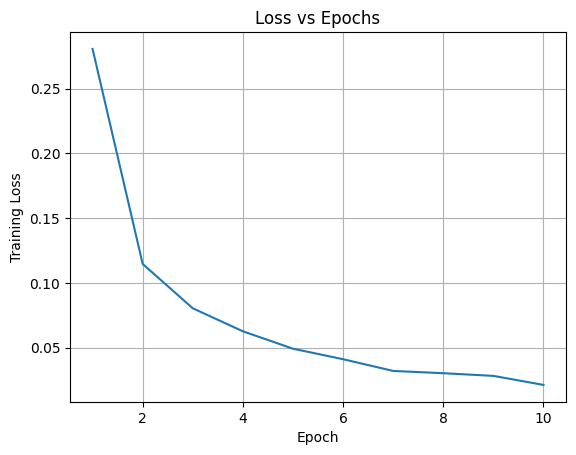

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FeedforwardNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

train_loss = train(model, device, train_loader, optimizer, criterion, epochs=10)

# Plot Loss vs Epochs
plt.plot(range(1, 11), train_loss)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss vs Epochs")
plt.grid(True)
plt.show()


Test Accuracy: 97.35%


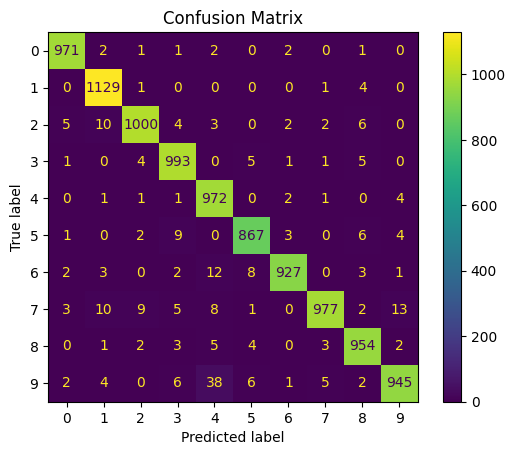

In [13]:
y_pred, y_true = evaluate(model, device, test_loader)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))
disp.plot(cmap='viridis')
plt.title("Confusion Matrix")
plt.show()


In [14]:
torch.save(model.state_dict(), "mnist_feedforward.pth")
